# **PLQY_individual**

_by Felix Eickemeyer_

Calculation of PLQY for each sample.

In [1]:
import os
from os import getcwd, listdir
import thot
from thot import ThotProject
import importlib
from importlib import reload
import warnings

from FTE_analysis_libraries import PLQY as lqy
from FTE_analysis_libraries import Spectrum as spc
from FTE_analysis_libraries.General import f1240, Vsq, V_loss, QFLS

In [2]:
# Initializes Thot project
db = ThotProject( dev_root = r'PLQY_results' )
root = db.find_container( dict(_id = db.root) )

In [3]:
#Perovskite

if 'sample_type' in root.metadata:
    which_sample = root.metadata[ 'sample_type' ]

else:
    # default sample type
    #which_sample = 'Haizhou-FAPbI3'
    which_sample = 'FAPbI3'

    #DSC
    #which_sample = 'Yameng DSC'
    #which_sample = 'dye on TiO2'
    #which_sample = 'dye on Al2O3'
    #which_sample = 'Coumarin 153'
    #which_sample = 'MS5'
    #which_sample = 'XY1b'

param = lqy.exp_param(which_sample = which_sample, excitation_laser = None, PL_left = None, PL_right = None, PL_peak = None, corr_offs_left = 40, corr_offs_right = 50, PL_peak_auto = False, eval_Pb = False)

In [4]:
samples = db.find_assets({'type' : 'calibrated PL spectrum'})
names = list({sample.metadata['name'] for sample in samples})
names.remove('no sample')
if 'exclude' in root.metadata:
    for exc in root.metadata[ 'exclude' ]:
        names.remove(exc)
if db.dev_mode():
    print( names )

['3LI_dev-target', '3AA_dev-target', '2JG_dev-ctrl', '2OH_dev-target', '2OC_dev-ctrl', '2LG_dev-ctrl', '1IE_dev-ctrl', '3MF_dev-target', '2KD_dev-target', '2LGb_dev-ctrl']


In [5]:
La = lqy.find({'metadata.name' : 'no sample', 'metadata.em_filter' : param.laser_marker}, samples, show_details = ( True and db.dev_mode() ))
Pa = lqy.find({'metadata.name' : 'no sample', 'metadata.em_filter' : param.PL_marker}, samples, show_details = ( True and db.dev_mode() ))

no sample--ip_laser--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_650BPF.csv
no sample--ip_laser--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv


In [8]:
from importlib import reload
reload(lqy)

<module 'FTE_analysis_libraries.PLQY' from 'c:\\users\\dreickem\\switchdrive\\work\\python\\my_packages\\fte-analysis-libraries-main\\FTE_analysis_libraries\\PLQY.py'>


0____________________________
3LI_dev-target
3LI_dev-target--ip_outofbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_650BPF.csv
3LI_dev-target--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_650BPF.csv
3LI_dev-target--ip_outofbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv
3LI_dev-target--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv
3LI_dev-target--fs--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv


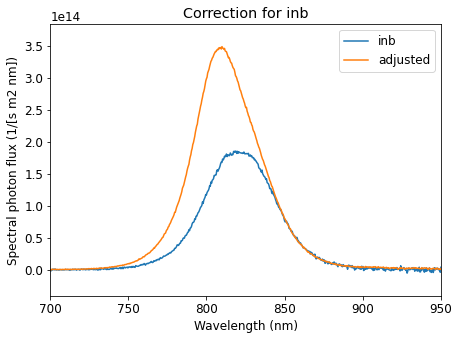

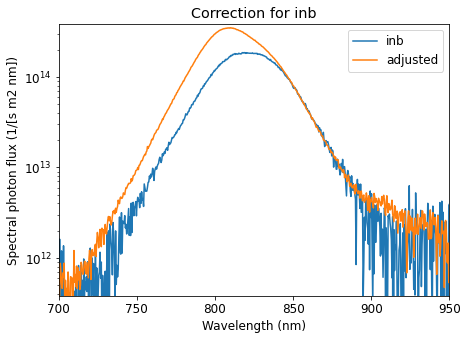

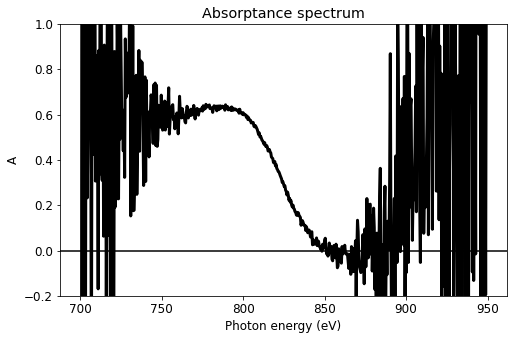

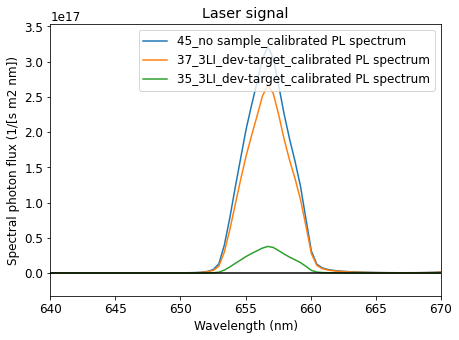

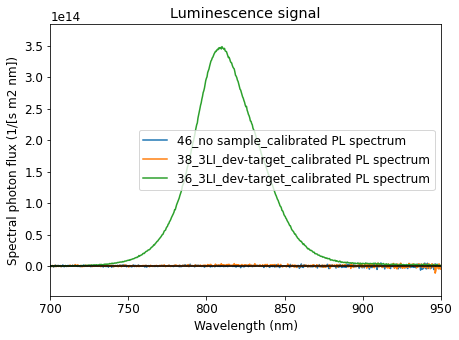

La = 1.32e+18 1/(s m2)
Lb = 1.09e+18 1/(s m2)
Lc = 1.56e+17 1/(s m2)
Pa = 0.00e+00 1/(s m2)
Pb = 0.00e+00 1/(s m2)
Pc = 1.82e+16 1/(s m2)
A = 1 - Lc/Lb = 85.8 %
PLQY = (Pc - (1 - A) * Pb) / (La * A) = 1.61e-02

1____________________________
3AA_dev-target
3AA_dev-target--ip_outofbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_650BPF.csv
3AA_dev-target--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_650BPF.csv
3AA_dev-target--ip_outofbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv
3AA_dev-target--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv
3AA_dev-target--fs--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv


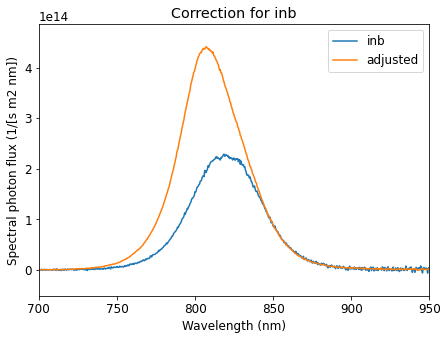

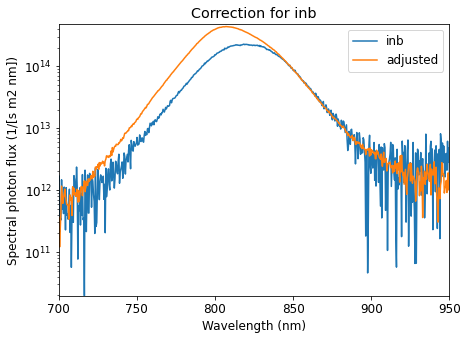

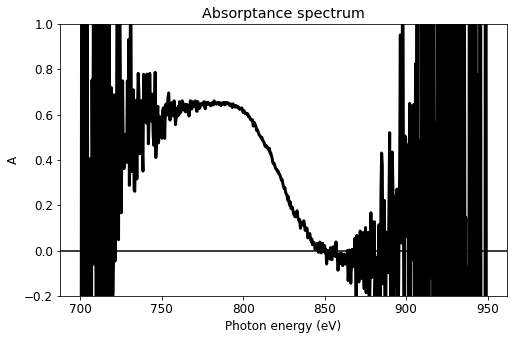

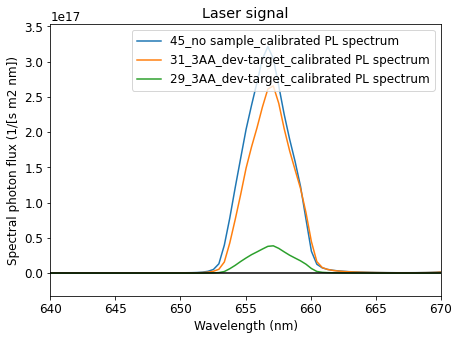

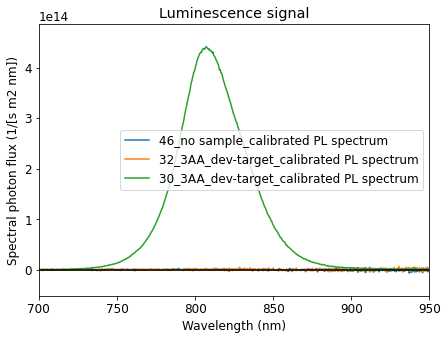

La = 1.32e+18 1/(s m2)
Lb = 1.08e+18 1/(s m2)
Lc = 1.59e+17 1/(s m2)
Pa = 0.00e+00 1/(s m2)
Pb = 0.00e+00 1/(s m2)
Pc = 2.29e+16 1/(s m2)
A = 1 - Lc/Lb = 85.4 %
PLQY = (Pc - (1 - A) * Pb) / (La * A) = 2.04e-02

2____________________________
2JG_dev-ctrl
2JG_dev-ctrl--ip_outofbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_650BPF.csv
2JG_dev-ctrl--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_650BPF.csv
2JG_dev-ctrl--ip_outofbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv
2JG_dev-ctrl--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv
2JG_dev-ctrl--fs--laser_657nm_3.5mW_OD1--Andor_0.1s_50acc_300lmm_center850nm_700LPF.csv


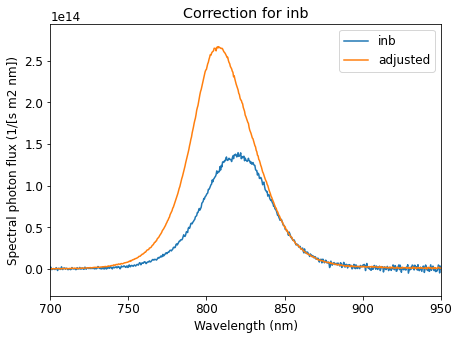

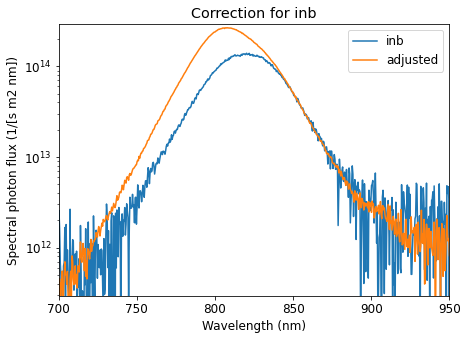

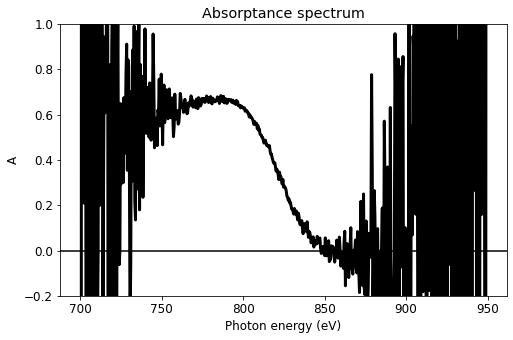

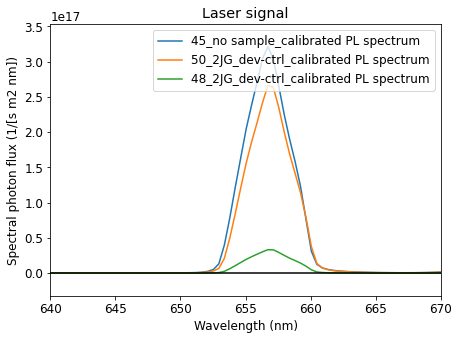

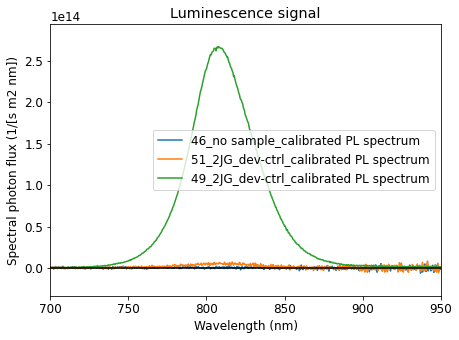

La = 1.32e+18 1/(s m2)
Lb = 1.09e+18 1/(s m2)
Lc = 1.37e+17 1/(s m2)
Pa = 0.00e+00 1/(s m2)
Pb = 0.00e+00 1/(s m2)
Pc = 1.38e+16 1/(s m2)
A = 1 - Lc/Lb = 87.4 %
PLQY = (Pc - (1 - A) * Pb) / (La * A) = 1.20e-02


KeyboardInterrupt: 

In [9]:
# You can change maxNumberOutputs in settings: click on Menu bar → Settings → Advanced Settings Editor → Notebook → set maxNumberOutputs in the User Preferences tab, like:
# {
#     "maxNumberOutputs": 0
# }

#idx = 0
#param.eval_Pb = True
show_details = ( True and db.dev_mode() )
save_plots = ( False or not db.dev_mode() )


for idx in range(len(names)):

    sample_name = names[idx]


    print(f'\n{idx:}____________________________')
    print(sample_name)

    group = thot.filter({'metadata.name' : sample_name}, samples)
    Lb = lqy.find({'metadata.em_filter' : param.laser_marker, 'metadata.inboob' : 'outofbeam'}, group, show_details = show_details)
    Lc = lqy.find({'metadata.em_filter' : param.laser_marker, 'metadata.inboob' : 'inbeam'}, group, show_details = show_details)
    Pb = lqy.find({'metadata.em_filter' : param.PL_marker, 'metadata.inboob' : 'outofbeam'}, group, show_details = show_details)
    Pc = lqy.find({'metadata.em_filter' : param.PL_marker, 'metadata.inboob' : 'inbeam'}, group, show_details = show_details)
    fs = lqy.find({'metadata.em_filter' : param.PL_marker, 'metadata.fsip' : 'fs'}, group, show_details = show_details)

    if ( Lb is None ) or ( Lc is None ) or (fs is None) or ( Pc is None ) or ( (Pb is None) and (param.eval_Pb == True) ):
        warnings.warn("Attention: One or more of the necessary data is missing, PLQY can't be evaluated!")
        continue

    sPL = lqy.PLQY_dataset(db, La, Lb, Lc, Pa, Pb, Pc, fs, sample_name, param)
    #sPL.fs.plot(yscale = 'linear', title = sPL.fs_asset.metadata['orig_fn'])

    sPL.find_PL_peak()
    sPL.inb_adjust(adj_factor = None, show_adjust_factor = False, save_plots = save_plots, show_plots = show_details)
    sPL.calc_abs(what = 'inb', save_plots = show_details, show_plot = show_details)

    if param.eval_Pb == True:
        sPL.oob_adjust(adj_factor = None, show_adjust_factor = True, save_plots = save_plots, show_plots = show_details)
        sPL.calc_abs(what = 'oob', save_plots = show_details, show_plot = show_details)

    sPL.calc_PLQY(show = show_details, show_plots = show_details, save_plots = save_plots, show_lum = 'linear')

    sPL.abs_pf_spec(nsuns = 1)

    sPL.save_asset()